### **This notebook is a Turkish translation of the basic_deep_learning_model_in_medical_imaging.ipynb.**

### **Author: Turkay Kart** 

*   **Email**:    t.kart@imperial.ac.uk
*   **Github**:   [@turkaykart](https://github.com/turkaykart)
*   **Twitter**:  [@turkaykart](https://twitter.com/turkaykart)

This notebook is available at [my Github page](https://github.com/turkaykart/retinal_oct_classification_pytorch/).

# **Medikal Goruntulemede Derin Ogrenme Modeli Gelistirme:** 

###PyTorch ile Retinal OCT Goruntulerinin Siniflandirilmasi


Bu notebookta, derin ogrenmenin medikal goruntulemedeki temel yapi taslari ile ilgili konusacagiz. Amacimiz, bu alanla ilgilenen kisilere PyTorch ile medikal derin ogrenmenin nasil yapildigini tanitmaktir. Burada ornek olarak retinal OCT goruntulerini diyabetik retinopatili ve saglikli olarak siniflandiracagiz.

## **Gelistirme Ortami ve Kutuphaneler**

Bu notebooku [Google Colab](https://colab.research.google.com/) ortaminda herhangi bir yukleme yapmadan internet tarayicinizda calistirabilirsiniz. Alternatif olarak, kendi bilgisayarinizda [Jupyter Notebook](https://jupyter.org/) veya [Lab](https://jupyter.org/) ile [PyTorch](https://pytorch.org/) yukleyerek de calistirabilirsiniz.

## **Veri Seti**

Veri setimiz olarak acik kaynak "OCTID: Optical Coherence Tomography Image Database" kullanacagiz [1]. Yuksek cozunurluklu retinal OCT resimlerden olusan veri setinde su etiketler mevcuttur:

1.   Normal (206 resim)
2.   Diabetic Retinopathy (107 resim)
3.   Macular Hole (102 resim)
4.   Age-related Macular Degeneration (55 resim)
5.   Central Serous Retinopathy (102 resim)


Biz burada veri setimiz olarak sadece diyabetik retinopatili ve saglikli resimlerden 100'er adet secip modelimizi egitecegiz. Veri seti ve daha fazla bilgi asagidaki linklerde bulunmaktadir:

1.   Indirme Link 1: https://dataverse.scholarsportal.info/dataverse/OCTID
2.   Alternatif Indirme Link 2: http://doi.org/10.3886/E108503V1
3.   Makale Link: https://arxiv.org/ftp/arxiv/papers/1812/1812.07056.pdf


[1] Peyman Gholami, Priyanka Roy, Mohana Kuppuswamy Parthasarathy, Vasudevan Lakshminarayanan, "OCTID: Optical Coherence Tomography Image Database", arXiv preprint arXiv:1812.07056, (2018)

## **Veri Setinin Duzenlenmesi**

Veri setini yukaridaki linkleri kullanarak indirdikten sonra, veri asagidaki gibi 3 klasore bolunmelidir:

```
demo_retinal_oct/train/
```
```
demo_retinal_oct/val/
```
```
demo_retinal_oct/test/
```

Bu 3 klasorun her biri diyabetik retinopati ve saglikli olarak adlandirilmis 2 klasor ve asagida belirtilmis oranlarda retinal OCT resimleri icermelidir:

```
demo_retinal_oct/train/diabetic_retinopathy/    (Butun diyabetik retinopati resimlerin %80)
demo_retinal_oct/train/healthy/                 (Butun saglikli resimlerin %80)
```
```
demo_retinal_oct/val/diabetic_retinopathy/      (Butun diyabetik retinopati resimlerin %10)
demo_retinal_oct/val/healthy/                   (Butun saglikli resimlerin %10)
```
```
demo_retinal_oct/test/diabetic_retinopathy/     (Butun diyabetik retinopati resimlerin %10)
demo_retinal_oct/test/healthy/                  (Butun saglikli resimlerin %10)
```

Eger bu klasor organizasyonu degistirirseniz, "Veri Yukleme, On Isleme ve Veri Artirimi" bolumundeki "Veri Yukleme" kodunu degistirmeniz gerekecektir.

In [ ]:
# !mkdir demo_retinal_oct
# !unzip demo_retinal_oct.zip -d demo_retinal_oct/

## **Yardimci metotlar ve Kutuphaneleri Tanimlama**

In [ ]:
import copy
import numpy as np

import torch
import torchvision
from torchvision import transforms

In [ ]:
# Gorsellestirme Metodu
import matplotlib.pyplot as plt
%matplotlib inline

def show_tensors(images, mean=np.array([0.5, 0.5, 0.5]), std=np.array([0.5, 0.5, 0.5])):
    images = torchvision.utils.make_grid(images)
    images = images.numpy().transpose((1, 2, 0))
    images = np.clip(images * std + mean, 0, 1)
    plt.figure(figsize=(25, 25))
    plt.axis('off')
    plt.imshow(images)
    plt.show()

## **Medikal Goruntulemede Derin Ogrenme Adimlari**



Sekil 1 medikal derin ogrenme uygulamalari gelistirilirken takip edilen temel adimlari gostermektedir. Bu notebookta, biz siniflandirma modelimiz icin bu adimlari sirasiyla takip edecegiz.
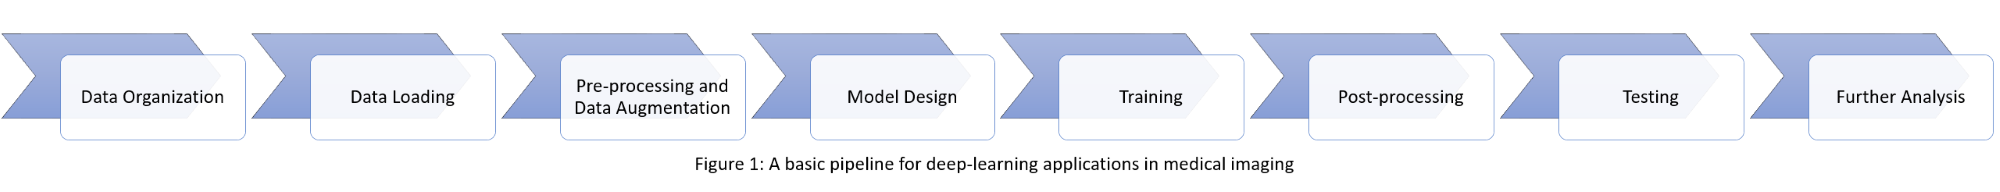


## **Veri Yukleme, On isleme ve Veri Artirimi**

In [ ]:
torch.manual_seed(12)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# On isleme ve Veri Artirimi
train_transform = transforms.Compose([
    transforms.CenterCrop(500),
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.CenterCrop(500),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# Veri Yukleme
train_dataset = torchvision.datasets.ImageFolder('demo_retinal_oct/train/', train_transform)
val_dataset = torchvision.datasets.ImageFolder('demo_retinal_oct/val/', test_transform)
test_dataset = torchvision.datasets.ImageFolder('demo_retinal_oct/test/', test_transform)

print('80% for training, 10% for validation, 10% for testing\n')
print('Number of images [training]: {}'.format(len(train_dataset)))
print('Number of images [validation]: {}'.format(len(val_dataset)))
print('Number of images [testing]: {}'.format(len(test_dataset)))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=4)

label_names = train_dataset.classes
print('\nLabel Names: {}'.format(label_names))

80% for training, 10% for validation, 10% for testing

Number of images [training]: 160
Number of images [validation]: 20
Number of images [testing]: 20

Label Names: ['diabetic_retinopathy', 'healthy']


## **Veri Gorsellestirme**

Ground-Truth: healthy, healthy, healthy, healthy


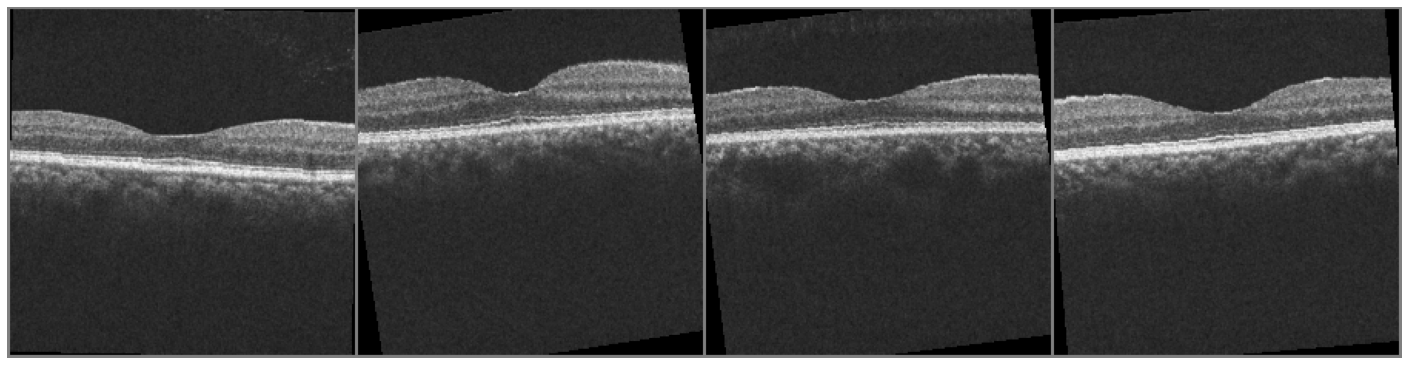

In [ ]:
num_batches = 1
for idx, data in enumerate(train_dataloader, 0):
    if idx < num_batches:
        images, labels = data
        print('Ground-Truth: {}'.format(', '.join([label_names[x] for x in labels])))
        show_tensors(images)

## **Model Tasarimi**

Siniflandirma islemi icin onceden egitilmis (pre-trained) VGG11 mimarisini kullanacagiz [1]. Modelimizi 1000 sinif yerine sadece 2 sinif cikti vermek uzere ayarladiktan sonra retinal OCT resimleri ile egitecegiz.

[1] Simonyan, Karen, and Andrew Zisserman. "Very deep convolutional networks for large-scale image recognition." arXiv preprint arXiv:1409.1556 (2014).

In [ ]:
model = torchvision.models.vgg11(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.classifier[6] = torch.nn.Linear(in_features=model.classifier[6].in_features, out_features=len(label_names))
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

## **Egitme and Dogrulama Metotlari**

In [ ]:
def train(epoch, model, criterion, optimizer, scheduler):
    model.train()
    running_loss, running_correct, running_total = 0.0, 0.0, 0.0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        
        with torch.set_grad_enabled(True):
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        _, preds = outputs.max(1)
        running_loss += loss.item() * images.size(0)
        running_correct += torch.sum(preds == labels.data)
        running_total += images.size(0)

        epoch_loss = running_loss/running_total
        epoch_acc = running_correct.double()/running_total 

    print('Train epoch: {} loss: {:.4f} acc: {:.4f}'.format(epoch + 1, epoch_loss, epoch_acc))
    
    scheduler.step()

    return model, epoch_loss, epoch_acc

In [ ]:
def val(epoch, model, criterion, best_acc, best_model_loc):
    model.eval()
    running_loss, running_correct, running_total = 0.0, 0.0, 0.0

    for images, labels in val_dataloader:
        images, labels = images.to(device), labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(images)
            loss = criterion(outputs, labels)

        _, preds = outputs.max(1)
        running_loss += loss.item() * images.size(0)
        running_correct += torch.sum(preds == labels.data)
        running_total += images.size(0)
        
        epoch_loss = running_loss/running_total
        epoch_acc = running_correct.double()/running_total 

    print('Valid epoch: {} loss: {:.4f} acc: {:.4f}'.format(epoch + 1, epoch_loss, epoch_acc))

    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_weights = copy.deepcopy(model.state_dict())
        torch.save(best_model_weights, best_model_loc)
        model.load_state_dict(best_model_weights)

    return model, epoch_loss, epoch_acc, best_acc

## **Derin Ogrenme Modelinin Egitimi**

In [ ]:
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.00025, momentum=0.9)
num_epochs = 10
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

train_loss, train_acc, val_loss, val_acc = [], [], [], []
best_model_loc = 'best_model.pth'
best_acc = 0.0
for epoch in range(num_epochs):
    model, epoch_loss, epoch_acc = train(epoch, model, criterion, optimizer, scheduler)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    model, epoch_loss, epoch_acc, best_acc = val(epoch, model, criterion, best_acc, best_model_loc)
    val_loss.append(epoch_loss)
    val_acc.append(epoch_acc)

Train epoch: 1 loss: 0.5609 acc: 0.6875
Valid epoch: 1 loss: 0.3992 acc: 0.8000
Train epoch: 2 loss: 0.2852 acc: 0.9062
Valid epoch: 2 loss: 0.1852 acc: 0.9000
Train epoch: 3 loss: 0.2170 acc: 0.9313
Valid epoch: 3 loss: 0.1272 acc: 0.9500
Train epoch: 4 loss: 0.1926 acc: 0.9563
Valid epoch: 4 loss: 0.0986 acc: 1.0000
Train epoch: 5 loss: 0.1616 acc: 0.9563
Valid epoch: 5 loss: 0.0942 acc: 0.9500
Train epoch: 6 loss: 0.1291 acc: 0.9625
Valid epoch: 6 loss: 0.0937 acc: 0.9500
Train epoch: 7 loss: 0.1270 acc: 0.9875
Valid epoch: 7 loss: 0.0915 acc: 0.9500
Train epoch: 8 loss: 0.1494 acc: 0.9563
Valid epoch: 8 loss: 0.0908 acc: 0.9500
Train epoch: 9 loss: 0.1450 acc: 0.9563
Valid epoch: 9 loss: 0.0814 acc: 0.9500
Train epoch: 10 loss: 0.1336 acc: 0.9438
Valid epoch: 10 loss: 0.0787 acc: 0.9500


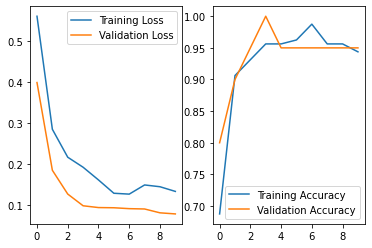

In [ ]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(train_loss, label='Training Loss')
axs[0].plot(val_loss, label='Validation Loss')
axs[0].legend()
axs[1].plot(train_acc, label='Training Accuracy')
axs[1].plot(val_acc, label='Validation Accuracy')
axs[1].legend()
plt.show()

## **Test Asamasi**

Predictions: healthy, diabetic_retinopathy, diabetic_retinopathy, healthy
Ground-Truth: healthy, diabetic_retinopathy, diabetic_retinopathy, healthy


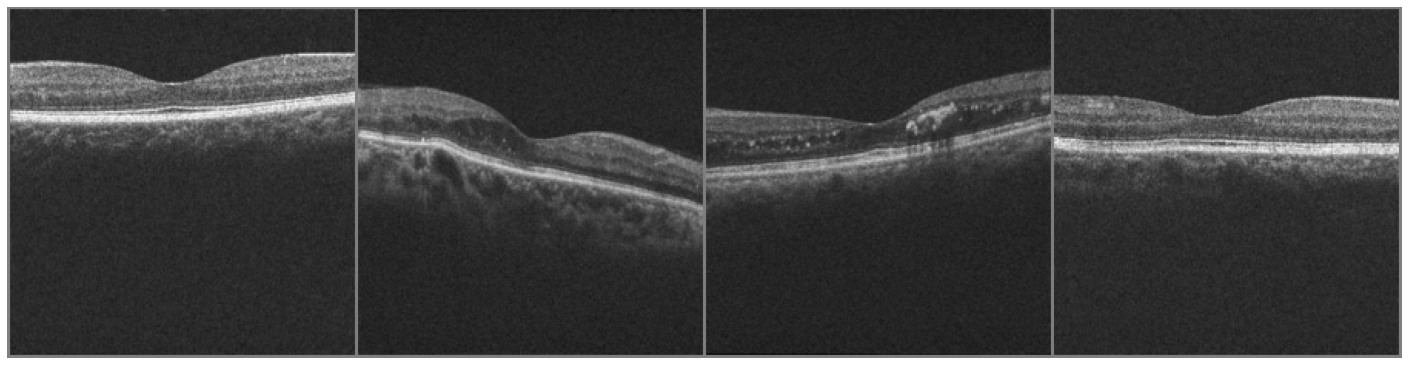


Testing accuracy: 90.0%


In [ ]:
num_correct, num_total = 0, 0
for images, labels in test_dataloader:
    model.eval()
    images = images.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(images)
        _, predicted = outputs.max(1)

    num_correct += torch.sum(predicted.cpu() == labels.data)
    num_total += images.size(0) 
    
    if num_total <= 4:
        print('Predictions: {}'.format(', '.join([label_names[x] for x in predicted])))
        print('Ground-Truth: {}'.format(', '.join([label_names[x] for x in labels])))
        images = images.cpu()
        show_tensors(images)
    
print('\nTesting accuracy: {}%'.format(100*num_correct.double().item()/num_total))

## **Ilave Notlar**

Bir sonraki adim olarak, derin ogrenme tabanli siniflandiricimizin performansini yukseltmek icin modelimizi ve hyperparametrelerimizi optimize edebiliriz. PyTorch ile ilgili daha fazla kaynaga [PyTorch websitesinden](https://pytorch.org/tutorials/) ulasabilirsiniz.

Oneri ve sorulariniz varsa, benimle email (t.kart@imperial.ac.uk) veya Twitter ([@turkaykart](https://twitter.com/turkaykart)) uzerinden iletisime gecebilirsiniz.

Eger ki arastirmalarinizda bu notebooktaki kodlara atif yapmak isterseniz:

`Turkay Kart, "Building a Basic Deep Learning Model in Medical Imaging: Classification of Retinal OCT Images in PyTorch", (2021), GitHub repository, https://github.com/turkaykart/retinal_oct_classification_pytorch`

---

```
@misc{kart2021retinal,
  author = {Kart, Turkay},
  title = {Building a Basic Deep Learning Model in Medical Imaging: Classification of Retinal OCT Images in PyTorch},
  year = {2021},
  publisher = {GitHub},
  journal = {GitHub repository},
  howpublished = {\url{https://github.com/turkaykart/retinal_oct_classification_pytorch}},
}
```



